In [10]:
import pathlib
from math import sqrt

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

In [12]:
TEX_RC_PARAMS = {
    'backend': 'ps',
    'text.latex.preamble': [r'\usepackage{gensymb}'],
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'font.family': 'serif',
}

In [13]:
NOTEBOOK_DIR = pathlib.Path.cwd()

DATA_FOLDER = NOTEBOOK_DIR / "yield_data"
if not DATA_FOLDER.exists():
    raise ValueError("Data folder with results not found.")

IMG_FOLDER = NOTEBOOK_DIR / "img"
IMG_FOLDER.mkdir(parents=True, exist_ok=True)

In [15]:
AMP_LABELS = ["low", "mid", "high"]
AMP_VALS = [0.1, 0.3, 0.5]

MIN_RES_VAR = 0.001
MAX_RES_VAR = 0.1
NUM_SEEDS = 6000
DISTANCES = [3, 5, 7]

collision_arrs = []
for amp_label in AMP_LABELS:
    arrs = []
    for distance in DISTANCES:
        arr_name = f"mixed_device_yield_d_{distance}_resist_{MIN_RES_VAR}_{MAX_RES_VAR}_seeds_{NUM_SEEDS}_v3_{amp_label}_drive.nc"
        arr = xr.load_dataarray(DATA_FOLDER / arr_name)
        arrs.append(arr)

    merged_arr = xr.concat(arrs, dim="distance")
    collision_arrs.append(merged_arr)

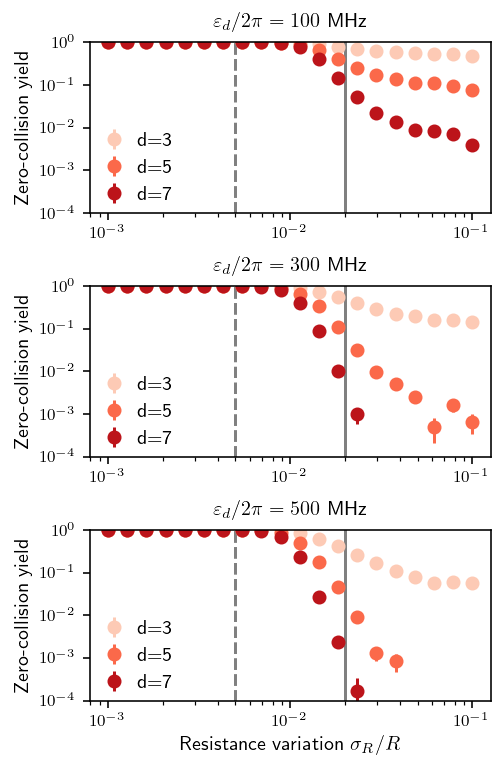

In [27]:
SAVE_IMAGE = True
MAX_RES_VAR = 0.02
LA_RES_VAR = 0.005
CMAP_NAME = "Reds"


cmap = plt.get_cmap(CMAP_NAME)
colors = [cmap(val) for val in (0.2, 0.5, 0.8)]

num_drives = len(AMP_LABELS)

with plt.rc_context(TEX_RC_PARAMS):
    fig, axs = plt.subplots(
        nrows = num_drives, 
        figsize=(3.39, 5.237838054655359), 
        constrained_layout=True
    )

    for drive_ind, col_arr in enumerate(collision_arrs):
        device_yield = col_arr.mean(dim="seed")
        yield_stds = col_arr.std(dim="seed")
        yield_sems = yield_stds / sqrt(col_arr.seed.size)

        for dist_ind, distance in enumerate(DISTANCES):
            axs[drive_ind].axvline(MAX_RES_VAR, color="grey", linestyle="-")
            axs[drive_ind].axvline(LA_RES_VAR, color="grey", linestyle="--")

            color = colors[dist_ind]
            label = f"d={distance}"

            axs[drive_ind].errorbar(
                device_yield.resist_var, 
                device_yield.sel(distance=distance),
                yield_sems.sel(distance=distance),
                marker="o",
                color=color,
                linestyle="",
                label=label,
            )

            axs[drive_ind].set_yscale("log")
            axs[drive_ind].set_ylim(1e-4, 1)
            axs[drive_ind].set_yticks([0.0001, 0.001, 0.01, 0.1, 1])
            axs[drive_ind].set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"])
            axs[drive_ind].set_ylabel(r"Zero-collision yield")

            axs[drive_ind].set_xscale("log")
            axs[drive_ind].set_xticks([0.001, 0.01, 0.1])
            axs[drive_ind].set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

            axs[drive_ind].legend(
                frameon=False, 
                loc="lower left",
                handletextpad=0.4,
                labelspacing=0.4,
                borderpad=0.4,
                markerscale=1.0,
                handlelength=1.5,
                borderaxespad=0.05,
                columnspacing=0.4
            )      

            axs[drive_ind].set_title(r"$\varepsilon_{d}/2\pi = %d $ MHz" % (AMP_VALS[drive_ind] * 1e3))
    
    axs[-1].set_xlabel(r"Resistance variation $\sigma_{R}/R$")
    
    image_name = "zero_col_yeild_vs_resist_var_d_3_7_drive_amp_0.1_0.5"
    if SAVE_IMAGE:
        for file_format in ('pdf', 'png'):
            full_name = f"{image_name}.{file_format}"
            fig.savefig(
                IMG_FOLDER / full_name,  
                dpi=300,  
                bbox_inches='tight', 
                transparent=True, 
                format=file_format,
                pad_inches=0
            )
plt.show()